・精度評価は、評価関数「F1Score」を使用

データの事前情報\
0	id	顧客ID（インデックスとして使用）\
1	loan_amnt	借入総額\
2	term	返済期間\
3	interest_rate	金利\
4	grade	グレード A1～F5\
5	employment_length	勤続年数\
6	purpose	借入の目的\
7	credit_score	信用スコア\
8	application_type	借入時の申請方式\
9	loan_status	返済状況（目的変数）

#### ・前処理

In [ ]:
!pip install category_encoders

     |████████████████████████████████| 82 kB 346 kB/s 


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import category_encoders as ce

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')
sub = pd.read_csv('submit.csv', encoding = 'UTF-8', names=['id', 'ans'])

In [ ]:
train.head()

,id,loan_amnt,term,interest_rate,grade,employment_length,purpose,credit_score,application_type,loan_status
0,0,1256.710800,5 years,10.603779,B1,5 years,debt_consolidation,680.431766,Individual,0
1,1,569.559607,3 years,17.305565,C5,3 years,house,713.063128,Individual,0
2,2,1118.838050,3 years,14.041342,C3,2 years,debt_consolidation,696.137378,Individual,1
3,3,610.721728,3 years,13.048348,C2,5 years,medical,656.373090,Individual,0
4,4,1180.026840,3 years,11.384862,B3,10 years,debt_consolidation,657.211233,Individual,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17500 entries, 0 to 17499
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 17500 non-null  int64  
 1   loan_amnt          17500 non-null  float64
 2   term               17500 non-null  object 
 3   interest_rate      17500 non-null  float64
 4   grade              17500 non-null  object 
 5   employment_length  17500 non-null  object 
 6   purpose            17500 non-null  object 
 7   credit_score       17500 non-null  float64
 8   application_type   17500 non-null  object 
 9   loan_status        17500 non-null  int64  
dtypes: float64(3), int64(2), object(5)
memory usage: 1.3+ MB


In [ ]:
X = train.drop(['loan_status'], axis=1)
y = train['loan_status']

In [ ]:
y.value_counts()

0    13741
1     3759
Name: loan_status, dtype: int64

In [ ]:
X = X.drop('id',axis=1)
test = test.drop('id',axis=1)

In [ ]:
#正規化
X['term'] = X['term'].str.replace(r"[a-z]",'')
X['employment_length'] = X['employment_length'].str.replace(r"[a-z]",'')
test['term'] = test['term'].str.replace(r"[a-z]",'')
test['employment_length'] = test['employment_length'].str.replace(r"[a-z]",'')

In [ ]:
#gradeの順序ラベルエンコーダ
mapping = [{'col':'grade',
           'mapping':{'A1':0,'A2':1,'A3':2,'A4':3,'A5':4,
                      'B1':5,'B2':6,'B3':7,'B4':8,'B5':9,
                      'C1':10,'C2':11,'C3':12,'C4':13,'C5':14,
                      'D1':15,'D2':16,'D3':17,'D4':18,'D5':19,
                      'E1':20,'E2':21,'E3':22,'E4':23,'E5':24,
                      'F1':25,'F2':26,'F3':27,'F4':28,'F5':29,
                      }}]
enc = ce.OrdinalEncoder(mapping=mapping)
enc.fit(X)
X = enc.transform(X)
test = enc.transform(test)

In [ ]:
#ダミー変数
train_pur = pd.get_dummies(X['purpose'],drop_first=True)
X = pd.concat([X,train_pur],axis=1)
X = X.drop('purpose',axis=1)

test_pur = pd.get_dummies(test['purpose'],drop_first=True)
test = pd.concat([test,test_pur],axis=1)
test = test.drop('purpose',axis=1)

In [ ]:
#ダミー変数
type_ = pd.get_dummies(X['application_type'],drop_first=True)
X = pd.concat([X,type_],axis=1)
X = X.drop('application_type',axis=1)

type_ = pd.get_dummies(test['application_type'],drop_first=True)
test = pd.concat([test,type_],axis=1)
test = test.drop('application_type',axis=1)

In [ ]:
X.corr().style.background_gradient(axis=None)

,loan_amnt,interest_rate,grade,credit_score,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,other,small_business,Joint App
loan_amnt,1.000000,0.175675,0.110366,0.159816,-0.023341,0.118571,-0.008447,-0.055005,0.006188,-0.054049,-0.084961,0.062628,0.104232
interest_rate,0.175675,1.000000,0.660977,-0.343825,-0.043588,-0.032220,-0.037795,0.039818,0.119872,0.052821,0.041972,0.047822,0.000958
grade,0.110366,0.660977,1.000000,-0.395255,-0.020649,-0.075327,-0.023543,0.092184,0.102553,0.057072,0.032764,0.051786,0.032283
credit_score,0.159816,-0.343825,-0.395255,1.000000,-0.056937,0.058213,0.054978,0.036270,-0.060063,-0.030530,-0.039668,0.001804,0.022596
credit_card,-0.023341,-0.043588,-0.020649,-0.056937,1.000000,-0.597725,-0.088543,-0.082106,-0.047126,-0.078186,-0.116082,-0.046600,0.106499
debt_consolidation,0.118571,-0.032220,-0.075327,0.058213,-0.597725,1.000000,-0.250441,-0.232234,-0.133295,-0.221148,-0.328336,-0.131807,-0.010517
home_improvement,-0.008447,-0.037795,-0.023543,0.054978,-0.088543,-0.250441,1.000000,-0.034401,-0.019745,-0.032759,-0.048637,-0.019525,-0.009021
house,-0.055005,0.039818,0.092184,0.036270,-0.082106,-0.232234,-0.034401,1.000000,-0.018310,-0.030378,-0.045101,-0.018105,-0.055759
major_purchase,0.006188,0.119872,0.102553,-0.060063,-0.047126,-0.133295,-0.019745,-0.018310,1.000000,-0.017436,-0.025887,-0.010392,-0.033911
medical,-0.054049,0.052821,0.057072,-0.030530,-0.078186,-0.221148,-0.032759,-0.030378,-0.017436,1.000000,-0.042948,-0.017241,-0.035391


In [ ]:
#相関関係の強いものから新たな特徴量を作成
X['grade_interest'] = X['grade'] * X['interest_rate']
test['grade_interest'] = test['grade'] * test['interest_rate']

In [ ]:
X.head()

,loan_amnt,term,interest_rate,grade,employment_length,credit_score,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,other,small_business,Joint App,grade_interest
0,1256.710800,5,10.603779,5,5,680.431766,0,1,0,0,0,0,0,0,0,53.018893
1,569.559607,3,17.305565,14,3,713.063128,0,0,0,1,0,0,0,0,0,242.277916
2,1118.838050,3,14.041342,12,2,696.137378,0,1,0,0,0,0,0,0,0,168.496099
3,610.721728,3,13.048348,11,5,656.373090,0,0,0,0,0,1,0,0,0,143.531828
4,1180.026840,3,11.384862,7,10,657.211233,0,1,0,0,0,0,0,0,0,79.694037


In [ ]:
#データの分割
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1234)

(array([5213., 2092., 1335., 1033., 1748.,  312.,   23.,   94.,  260.,
         140.]), array([649.6377049 , 664.95037963, 680.26305436, 695.57572909,
        710.88840382, 726.20107855, 741.51375328, 756.82642801,
        772.13910274, 787.45177747, 802.7644522 ]), <a list of 10 Patch objects>)

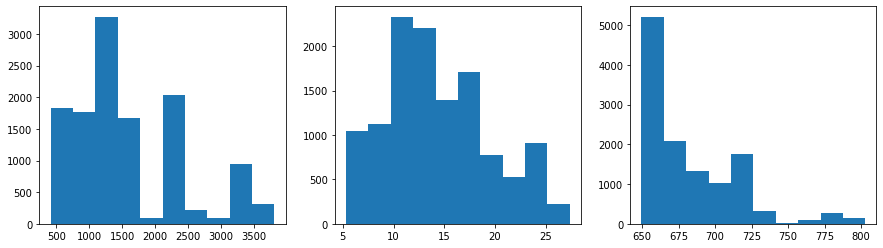

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(15,4))
ax[0].hist(X_train['loan_amnt'])
ax[1].hist(X_train['interest_rate'])
ax[2].hist(X_train['credit_score'])

#### ・正規化

単位の値による誤差をなくすために、正規化を行う

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

In [ ]:
std = StandardScaler()
X_train.loc[:, ['loan_amnt', 'interest_rate', 'credit_score', 'grade', 'term', 'employment_length']] = std.fit_transform(X_train.loc[:,['loan_amnt', 'interest_rate', 'credit_score', 'grade', 'term', 'employment_length']])
X_test.loc[:, ['loan_amnt', 'interest_rate', 'credit_score', 'grade', 'term', 'employment_length']] = std.transform(X_test.loc[:,['loan_amnt', 'interest_rate', 'credit_score', 'grade', 'term', 'employment_length']])
test.loc[:, ['loan_amnt', 'interest_rate', 'credit_score', 'grade', 'term', 'employment_length']] = std.transform(test.loc[:,['loan_amnt', 'interest_rate', 'credit_score', 'grade', 'term', 'employment_length']])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [ ]:
X_train.loc[:, ['grade_interest']] = std.fit_transform(X_train.loc[:,['grade_interest']])
X_test.loc[:, ['grade_interest']] = std.transform(X_test.loc[:,['grade_interest']])
test.loc[:, ['grade_interest']] = std.transform(test.loc[:,['grade_interest']])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [ ]:
X_train

,loan_amnt,term,interest_rate,grade,employment_length,credit_score,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,other,small_business,Joint App,grade_interest
1488,0.779644,-0.565095,-0.132022,-0.262092,-1.520732,0.981037,0,0,1,0,0,0,0,0,0,-0.357174
15376,-1.239520,-0.565095,-0.155564,0.443347,-0.187654,-0.720177,0,0,1,0,0,0,0,0,0,0.050814
8252,0.070353,1.769614,-0.070836,-0.438452,1.145424,1.009412,0,1,0,0,0,0,0,0,0,-0.443138
16976,-0.460246,-0.565095,-0.021499,0.443347,-1.254117,0.884876,0,1,0,0,0,0,0,0,0,0.118475
6762,0.881434,1.769614,0.046686,0.266987,-0.720885,0.016416,0,1,0,0,0,0,0,0,0,0.040982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8222,0.828913,-0.565095,1.514803,0.266987,-1.520732,-0.691990,0,1,0,0,0,0,0,0,0,0.724925
9449,-0.586136,-0.565095,-1.532000,-1.496610,-0.454270,3.747815,0,1,0,0,0,0,0,0,0,-1.200645
8471,-0.533317,1.769614,0.046223,0.443347,-0.720885,1.038023,0,1,0,0,0,0,0,0,0,0.152653
17048,-0.623136,-0.565095,0.043443,0.090627,0.878809,-0.626700,0,1,0,0,0,0,0,0,0,-0.072308


(array([5213., 2092., 1335., 1033., 1748.,  312.,   23.,   94.,  260.,
         140.]),
 array([-1.11351982, -0.607338  , -0.10115619,  0.40502563,  0.91120744,
         1.41738925,  1.92357107,  2.42975288,  2.93593469,  3.44211651,
         3.94829832]),
 <a list of 10 Patch objects>)

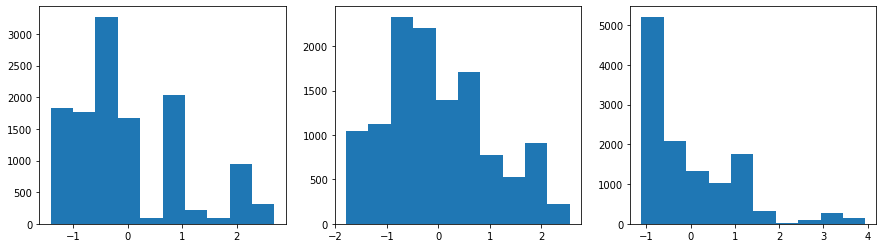

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(15,4))
ax[0].hist(X_train['loan_amnt'])
ax[1].hist(X_train['interest_rate'])
ax[2].hist(X_train['credit_score'])

#### ・SMOTE

今回はそこまで偏りのあるデータではないが、データ数の偏りを補正し、少数派のクラスに属するデータをオーバーサンプリングしておく。

In [ ]:
!pip install imblearn

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
x_resampled, y_resampled = sm.fit_sample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## ・モデル構築

#### ・ライブラリインポート

In [ ]:
import numpy as np
import pandas as pd
import datetime #日付データに一部処理を行うため、インポート
from sklearn.model_selection import cross_val_score #精度検証のためにインポート
from sklearn.model_selection import GridSearchCV #ハイパーパラメータチューニングのためにインポート
from sklearn.feature_selection import SelectFromModel #特徴量選択のためにインポート
from sklearn.linear_model import LassoCV #特徴量選択のためにインポート

#ロジスティック回帰のためにインポート
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, precision_score, recall_score, f1_score

#SVMのためにインポート
from sklearn.svm import SVC

#決定木のためにインポート
from sklearn.tree import DecisionTreeClassifier

#ランダムフォレストのためにインポート
from sklearn.ensemble import RandomForestClassifier

#アダブーストのためにインポート
from sklearn.ensemble import AdaBoostClassifier

#### k最近傍法

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

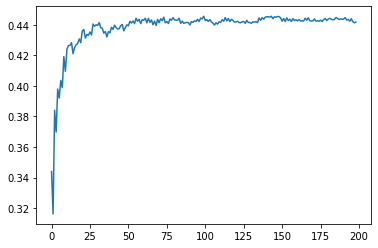

In [ ]:
accuracy = []
for k in range(1, 200):
    knn = KNeighborsClassifier(n_neighbors=k) # インスタンス生成。
    knn.fit(x_resampled, y_resampled)                 # モデル作成実行
    y_pred = knn.predict(X_test)              # 予測実行
    accuracy.append(metrics.f1_score(y_test, y_pred)) # 精度格納

plt.plot(accuracy)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=140) # インスタンス生成。n_neighbors:Kの数
knn.fit(x_resampled, y_resampled)                 # モデル作成実行
y_pred = knn.predict(X_test)    

In [ ]:
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_1 = f1_score(y_test, y_pred)

print(f'正解率: {acc:.3}')
print(f'Precision: {precision:.3}')
print(f'Recall: {recall:.3}')
print(f'F1: {f_1:.3}')

正解率: 0.586
Precision: 0.313
Recall: 0.771
F1: 0.445


#### ・ロジスティック回帰

In [ ]:
#デフォルト
clf = SGDClassifier(loss = "log", penalty = "none",random_state=1234)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_1 = f1_score(y_test, y_pred)

print(f'正解率: {acc:.3}')
print(f'Precision: {precision:.3}')
print(f'Recall: {recall:.3}')
print(f'F1: {f_1:.3}')

正解率: 0.788
Precision: 0.541
Recall: 0.0878
F1: 0.151


In [ ]:
#デフォルト
clf = SGDClassifier(loss = "log", penalty = "none",random_state=1234)
clf.fit(x_resampled,y_resampled)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_1 = f1_score(y_test, y_pred)

print(f'正解率: {acc:.3}')
print(f'Precision: {precision:.3}')
print(f'Recall: {recall:.3}')
print(f'F1: {f_1:.3}')

正解率: 0.607
Precision: 0.323
Recall: 0.755
F1: 0.452


In [ ]:
#L1正則化
clf_L1 = SGDClassifier(loss = "log", penalty = "l1", random_state=1234)
clf_L1.fit(x_resampled,y_resampled)

y_pred = clf_L1.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_1 = f1_score(y_test, y_pred)

print(f'正解率: {acc:.3}')
print(f'Precision: {precision:.3}')
print(f'Recall: {recall:.3}')
print(f'F1: {f_1:.3}')

正解率: 0.63
Precision: 0.334
Recall: 0.723
F1: 0.456


In [ ]:
#L2正則化
clf_L2 = SGDClassifier(loss = "log", penalty = "l2", random_state=1234)
clf_L2.fit(x_resampled,y_resampled)
y_pred = clf_L2.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_1 = f1_score(y_test, y_pred)

print(f'正解率: {acc:.3}')
print(f'Precision: {precision:.3}')
print(f'Recall: {recall:.3}')
print(f'F1: {f_1:.3}')

正解率: 0.606
Precision: 0.322
Recall: 0.755
F1: 0.452


In [ ]:
#標準化+L1(L2)正則化+パラメータチューニング
parameters = {'penalty':['l1', 'l2'], 'alpha':[0.0001,0.001, 0.01, 0.1, 1, 10, 100],'loss':['log']} # ここを編集する
model = SGDClassifier(random_state=1234)
clf = GridSearchCV(model, parameters, cv=3)
clf.fit(x_resampled, y_resampled)
print(clf.best_params_)

clf_2 = SGDClassifier(**clf.best_params_,random_state=1234)
clf_2.fit(x_resampled,y_resampled)

y_pred = clf_2.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_1 = f1_score(y_test, y_pred)

print(f'正解率: {acc:.3}')
print(f'Precision: {precision:.3}')
print(f'Recall: {recall:.3}')
print(f'F1: {f_1:.3}')

{'alpha': 0.001, 'loss': 'log', 'penalty': 'l1'}
正解率: 0.65
Precision: 0.343
Recall: 0.691
F1: 0.459


In [ ]:
#標準化+L1(L2)正則化+パラメータチューニング+特徴量選択
#標準化
#stdsc = StandardScaler()
#df[""] = stdsc.fit_transform(df[[""]].values)
#組み込み法(Lasso)
estimator = LassoCV(normalize = True, cv = 10, random_state = 1234)
sfm = SelectFromModel(estimator, threshold = 1e-5)
sfm.fit(x_resampled,y_resampled)

X_train_selected = sfm.transform(x_resampled)
X_test_selected = sfm.transform(X_test)

classifier = SGDClassifier(random_state=1234)
classifier.fit(X_train_selected, y_resampled)

parameters = {'penalty':['l1', 'l2'], 'alpha':[0.0001,0.001, 0.01, 0.1, 1, 10, 100],'loss':['log']} 
model = SGDClassifier(random_state=1234)
clf = GridSearchCV(model, parameters, cv=3)
clf.fit(X_train_selected, y_resampled)
print(clf.best_params_)

clf_2 = SGDClassifier(**clf.best_params_,random_state=1234)
clf_2.fit(X_train_selected,y_resampled)
y_pred = clf_2.predict(X_test_selected)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_1 = f1_score(y_test, y_pred)

print(f'正解率: {acc:.3}')
print(f'Precision: {precision:.3}')
print(f'Recall: {recall:.3}')
print(f'F1: {f_1:.3}')

{'alpha': 0.001, 'loss': 'log', 'penalty': 'l1'}
正解率: 0.65
Precision: 0.343
Recall: 0.691
F1: 0.459


#### ・決定木

In [ ]:
#デフォルト
clf = DecisionTreeClassifier(random_state=1234)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_1 = f1_score(y_test, y_pred)

print(f'正解率: {acc:.3}')
print(f'Precision: {precision:.3}')
print(f'Recall: {recall:.3}')
print(f'F1: {f_1:.3}')

正解率: 0.701
Precision: 0.317
Recall: 0.34
F1: 0.328


In [ ]:
#デフォルト
clf = DecisionTreeClassifier(random_state=1234)
clf = clf.fit(x_resampled, y_resampled)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_1 = f1_score(y_test, y_pred)

print(f'正解率: {acc:.3}')
print(f'Precision: {precision:.3}')
print(f'Recall: {recall:.3}')
print(f'F1: {f_1:.3}')

正解率: 0.686
Precision: 0.311
Recall: 0.379
F1: 0.342


In [ ]:
#決定木は正則化もないので+ハイパーパラメータ
#GridSearch
parameters = {'criterion':['gini', 'entropy'], 
              'max_depth':[i for i in range(1, 11)],
              'max_features':['auto','sqrt','log2'],
              'min_samples_leaf':[i for i in range(1, 11)]} # ここを編集する

model = DecisionTreeClassifier(random_state=1234)
clf = GridSearchCV(model, parameters, cv=3)
clf.fit(x_resampled, y_resampled)
print(clf.best_params_)
print(f'訓練スコア：{clf.best_score_}')

#ベストなパラメータでモデル構築
clf = DecisionTreeClassifier(**clf.best_params_, random_state=1234)
clf.fit(x_resampled, y_resampled)

#精度検証
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_1 = f1_score(y_test, y_pred)

print(f'正解率: {acc:.3}')
print(f'Precision: {precision:.3}')
print(f'Recall: {recall:.3}')
print(f'F1: {f_1:.3}')

{'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1}
訓練スコア：0.6940961183772423
正解率: 0.644
Precision: 0.331
Recall: 0.643
F1: 0.437


In [ ]:
#ハイパーパラメータ+特徴量選択

#特徴量選択
estimator = LassoCV(normalize = True, cv = 10, random_state = 1234)
sfm = SelectFromModel(estimator, threshold = 1e-5)
sfm.fit(x_resampled,y_resampled)

#選択された特徴量で訓練データを上書き
X_train_selected = sfm.transform(x_resampled)
X_test_selected = sfm.transform(X_test)

#ハイパーパラメータチューニング
parameters = {'criterion':['gini', 'entropy'], 'max_depth':[i for i in range(1, 11)],'max_features':['auto','sqrt','log2'], 'min_samples_leaf':[i for i in range(1, 11)]}
model = DecisionTreeClassifier(random_state=1234)
clf = GridSearchCV(model, parameters, cv=3)
clf.fit(X_train_selected, y_resampled)
print(clf.best_params_, clf.best_score_)

#最適なパラメータで学習器を訓練
clf_2 = DecisionTreeClassifier(**clf.best_params_,random_state=1234)
clf_2.fit(X_train_selected,y_resampled)

#テストデータで精度確認
y_pred = clf.predict(X_test_selected)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_1 = f1_score(y_test, y_pred)

print(f'正解率: {acc:.3}')
print(f'Precision: {precision:.3}')
print(f'Recall: {recall:.3}')
print(f'F1: {f_1:.3}')

{'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1} 0.6940961183772423
正解率: 0.644
Precision: 0.331
Recall: 0.643
F1: 0.437


#### ・ランダムフォレスト

In [ ]:
#デフォルト
clf = RandomForestClassifier(random_state=1234)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_1 = f1_score(y_test, y_pred)

print(f'正解率: {acc:.3}')
print(f'Precision: {precision:.3}')
print(f'Recall: {recall:.3}')
print(f'F1: {f_1:.3}')

正解率: 0.787
Precision: 0.512
Recall: 0.191
F1: 0.278


In [ ]:
#デフォルト
clf = RandomForestClassifier(random_state=1234)
clf.fit(x_resampled, y_resampled)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_1 = f1_score(y_test, y_pred)

print(f'正解率: {acc:.3}')
print(f'Precision: {precision:.3}')
print(f'Recall: {recall:.3}')
print(f'F1: {f_1:.3}')

正解率: 0.751
Precision: 0.414
Recall: 0.383
F1: 0.398


In [ ]:
#ハイパーパラメータ
#ハイパーパラメータチューニング
#さらにその3割（=全データの21%)を訓練データとして扱ってみます
#X_train_sample = pd.DataFrame(X_train).sample(frac = 0.30, random_state=1234)
#y_train_sample = pd.DataFrame(y_train).sample(frac = 0.30, random_state=1234)

parameters = {'max_depth':[2,4,6,None], 
              'min_samples_leaf':[1,3,5],
              'min_samples_split':[2,4,6]} #max_depth=Noneは深さが無限
              
model = RandomForestClassifier(random_state=1234)
clf = GridSearchCV(model, parameters, cv=3,)
clf.fit(x_resampled, y_resampled)
print(clf.best_params_, clf.best_score_)

#最適なパラメータで学習器を訓練
clf = RandomForestClassifier(**clf.best_params_,random_state=1234)
clf.fit(x_resampled, y_resampled)

#テストデータで精度確認
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_1 = f1_score(y_test, y_pred)

print(f'正解率: {acc:.3}')
print(f'Precision: {precision:.3}')
print(f'Recall: {recall:.3}')
print(f'F1: {f_1:.3}')

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2} 0.8389658995132866
正解率: 0.751
Precision: 0.414
Recall: 0.383
F1: 0.398


In [ ]:
#ハイパーパラメータ+特徴量選択
#特徴量選択
estimator = LassoCV(normalize = True, cv = 10, random_state = 1234)
sfm = SelectFromModel(estimator, threshold = 1e-5)
sfm.fit(x_resampled,y_resampled)

#選択された特徴量で訓練データを上書き
X_train_selected = sfm.transform(x_resampled)
X_test_selected = sfm.transform(X_test)

#ハイパーパラメータチューニング
parameters = {'max_depth':[2,4,6,None],  'min_samples_leaf':[1,3,5],'min_samples_split':[2,4,6]}
model = RandomForestClassifier(random_state=1234)
clf = GridSearchCV(model, parameters, cv=3,)
clf.fit(X_train_selected, y_resampled)
print(clf.best_params_, clf.best_score_)

#最適なパラメータで学習器を訓練
clf = RandomForestClassifier(**clf.best_params_,random_state=1234)
clf.fit(X_train_selected, y_resampled)

#テストデータで精度確認
y_pred = clf.predict(X_test_selected)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_1 = f1_score(y_test, y_pred)

print(f'正解率: {acc:.3}')
print(f'Precision: {precision:.3}')
print(f'Recall: {recall:.3}')
print(f'F1: {f_1:.3}')

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2} 0.8389658995132866
正解率: 0.751
Precision: 0.414
Recall: 0.383
F1: 0.398


#### ・アダブースト

In [ ]:
#デフォルト
clf = AdaBoostClassifier(DecisionTreeClassifier(random_state=1234))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_1 = f1_score(y_test, y_pred)

print(f'正解率: {acc:.3}')
print(f'Precision: {precision:.3}')
print(f'Recall: {recall:.3}')
print(f'F1: {f_1:.3}')

正解率: 0.699
Precision: 0.315
Recall: 0.34
F1: 0.327


In [ ]:
#デフォルト
clf = AdaBoostClassifier(DecisionTreeClassifier(random_state=1234))
clf.fit(x_resampled, y_resampled)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_1 = f1_score(y_test, y_pred)

print(f'正解率: {acc:.3}')
print(f'Precision: {precision:.3}')
print(f'Recall: {recall:.3}')
print(f'F1: {f_1:.3}')

正解率: 0.687
Precision: 0.323
Recall: 0.416
F1: 0.363


In [ ]:
#ハイパーパラメータ
#ハイパーパラメータチューニング
parameters = {'learning_rate':[0.1,0.5,1.0,1.5,2.0,10],
              }
model = AdaBoostClassifier(random_state=1234)
clf = GridSearchCV(model, parameters, cv=3,)
clf.fit(x_resampled, y_resampled)
print(clf.best_params_, clf.best_score_)

#最適なパラメータで学習器を訓練
clf = AdaBoostClassifier(**clf.best_params_,random_state=1234)
clf.fit(x_resampled, y_resampled)

#テストデータで精度確認
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_1 = f1_score(y_test, y_pred)

print(f'正解率: {acc:.3}')
print(f'Precision: {precision:.3}')
print(f'Recall: {recall:.3}')
print(f'F1: {f_1:.3}')

{'learning_rate': 1.5} 0.7250249974732585
正解率: 0.656
Precision: 0.345
Recall: 0.671
F1: 0.456


In [ ]:
#ハイパーパラメータ+特徴量選択
#特徴量選択
estimator = LassoCV(normalize = True, cv = 10, random_state = 1234)
sfm = SelectFromModel(estimator, threshold = 1e-5)
sfm.fit(x_resampled,y_resampled)

#選択された特徴量で訓練データを上書き
X_train_selected = sfm.transform(x_resampled)
X_test_selected = sfm.transform(X_test)

#ハイパーパラメータチューニング
parameters = {'learning_rate':[0.1,0.5,1.0,1.5,2,5]}
"""         'max_depth':[1,2,5,None]} #伸び放題の決定木
              min_samples_leaf=2,
              min_samples_split=2, 
              random_state=1234,
              criterion="gini",
              n_estimators=10}          """

model = AdaBoostClassifier(n_estimators=100,random_state=1234)
clf = GridSearchCV(model, parameters, cv=3)
clf.fit(X_train_selected, y_resampled)
print(clf.best_params_, clf.best_score_)

#最適なパラメータで学習器を訓練
clf = AdaBoostClassifier(**clf.best_params_,random_state=1234)
clf.fit(X_train_selected, y_resampled)

#テストデータで精度確認
y_pred = clf.predict(X_test_selected)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_1 = f1_score(y_test, y_pred)

print(f'正解率: {acc:.3}')
print(f'Precision: {precision:.3}')
print(f'Recall: {recall:.3}')
print(f'F1: {f_1:.3}')

{'learning_rate': 1.5} 0.7402034418351914
正解率: 0.656
Precision: 0.345
Recall: 0.671
F1: 0.456


#### ・LGB

In [ ]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
clf = lgb.LGBMClassifier(
    objective='binary',#回帰：regressuon, 分類：binary
    #num_leaves=64,
    #min_child_samples=20,
    #max_depth=7
)
clf.fit(x_resampled, y_resampled)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_1 = f1_score(y_test, y_pred)

print(f'正解率: {acc:.3}')
print(f'Precision: {precision:.3}')
print(f'Recall: {recall:.3}')
print(f'F1: {f_1:.3}')

正解率: 0.763
Precision: 0.446
Recall: 0.42
F1: 0.433


#### ベイズ最適化

In [ ]:
!pip install optuna
import optuna
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

In [ ]:
def objectives(trial):
    # optunaでのハイパーパラメータサーチ範囲の設定
    params = {
        'n_estimators' : trial.suggest_int("n_estimators", 10, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1.0)
    }
    # 学習+予測
    RFC = AdaBoostClassifier(**params,random_state=0)
    
    # kFold交差検定で決定係数を算出し、各セットの平均値を返す
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    scores = cross_validate(RFC, X=x_resampled, y=y_resampled,
                            scoring='f1',cv=kf)   

    return scores['test_score'].mean()

In [ ]:
%%time

# optunaによる最適化呼び出し
opt = optuna.create_study(direction='maximize')
opt.optimize(objectives, n_trials=10)


# 実行結果表示
print('最終トライアル回数:{}'.format(len(opt.trials)))
print('ベストトライアル:')
trial = opt.best_trial
print('値:{}'.format(trial.value))
print('パラメータ:')

for key, value in trial.params.items():
    print('{}:{}'.format(key, value))

[I 2021-11-13 15:42:02,668] A new study created in memory with name: no-name-acb86379-1a77-440f-97a7-2e24152781a2
[I 2021-11-13 15:42:25,478] Trial 0 finished with value: 0.6966679124671104 and parameters: {'n_estimators': 234, 'learning_rate': 0.000855899967028517}. Best is trial 0 with value: 0.6966679124671104.
[I 2021-11-13 15:42:40,617] Trial 1 finished with value: 0.6980764693849671 and parameters: {'n_estimators': 155, 'learning_rate': 0.00034385542305337695}. Best is trial 1 with value: 0.6980764693849671.
[I 2021-11-13 15:43:19,240] Trial 2 finished with value: 0.7151994252125754 and parameters: {'n_estimators': 396, 'learning_rate': 0.010679370450035496}. Best is trial 2 with value: 0.7151994252125754.
[I 2021-11-13 15:44:05,565] Trial 3 finished with value: 0.7150411245442442 and parameters: {'n_estimators': 477, 'learning_rate': 0.008952814912764395}. Best is trial 2 with value: 0.7151994252125754.
[I 2021-11-13 15:44:07,934] Trial 4 finished with value: 0.6980764693849671 

最終トライアル回数:10
ベストトライアル:
値:0.7459540719409503
パラメータ:
n_estimators:252
learning_rate:0.47590232043265146
CPU times: user 4min 25s, sys: 1.33 s, total: 4min 26s
Wall time: 4min 25s


結論：オーバーサンプリングを適用し、ハイパーパラメータチューニングによってアダブースト{'learning_rate': 1.5}で最も良い結果が得られた。